In [66]:
import torch

# Device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64

In [67]:
import os
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageFont

# Custom dataset that inherits from 
class Food11Dataset(Dataset):
    def __init__(self, dir, limit=None, transform=None):
        self.dir = dir
        self.transform = transform

        if limit is None:
            self.file_list = [file for file in os.listdir(dir) if file.endswith('.jpg')]
        else:
            self.file_list = [file for file in os.listdir(dir) if file.endswith('.jpg')][:limit]
        # Get the list of files in the directory, up to the limit
        

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = os.path.join(self.dir, self.file_list[idx])
        
        image = Image.open(path)

        noisy = self.add_watermark(image)
        
        if self.transform:
            image = self.transform(image)
            noisy = self.transform(noisy)

        label = int(self.file_list[idx].split('_')[0])

        return image, noisy, label
    
    def add_watermark(self, image):
        noisy = image.copy()

        draw = ImageDraw.Draw(noisy)

        text = '01.11.2023'

        font = ImageFont.truetype('arial.ttf', 30)

        # Specify the color of the watermark (in this case, white)
        text_color = (255, 255, 255)

        # Draw the watermark on the image
        draw.text((10, 10), text, font=font, fill=text_color)

        return noisy

In [68]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # N, 3, 128, 128
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # N, 16, 64, 64
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # N, 32, 32, 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # N, 64, 16, 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # N, 128, 8, 8
            nn.ReLU(),
        )

        # N, 128, 8, 8
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 64, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 32, 32, 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 16, 64, 64
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # N, 3, 128, 128
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


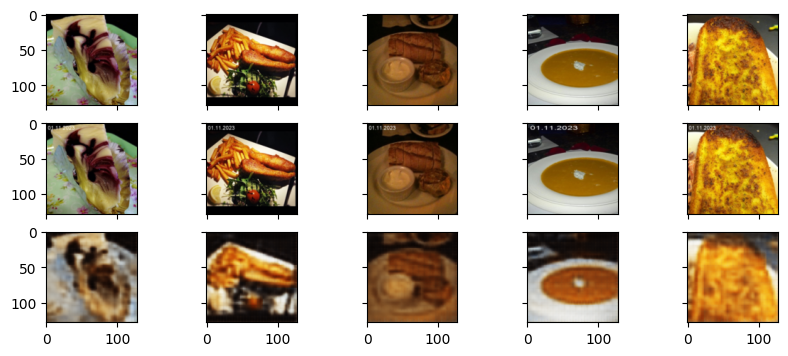

In [102]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

validate_data = Food11Dataset('food11/validation', transform=transform)

validate_dataloader = DataLoader(validate_data, batch_size=BATCH_SIZE, shuffle=True)

model = Autoencoder()
model.to(DEVICE)

model.load_state_dict(torch.load('latest.pth'))

model.eval()

fig, axes = plt.subplots(nrows=3, ncols=5, sharex=True, sharey=True, figsize=(10, 4))

for (images, watermarked, labels) in validate_dataloader:
    for i in range(5):
        denoised = watermarked[i].to(DEVICE)
        
        original = images[i].numpy().transpose((1, 2, 0))  # Transpose dimensions
        noisy = watermarked[i].numpy().transpose((1, 2, 0))  # Transpose dimensions

        denoised = model(denoised)
        denoised = denoised.cpu().detach().numpy().transpose((1, 2, 0))

        axes[0][i].imshow(original)
        axes[1][i].imshow(noisy)
        axes[2][i].imshow(denoised)
    break

plt.show()

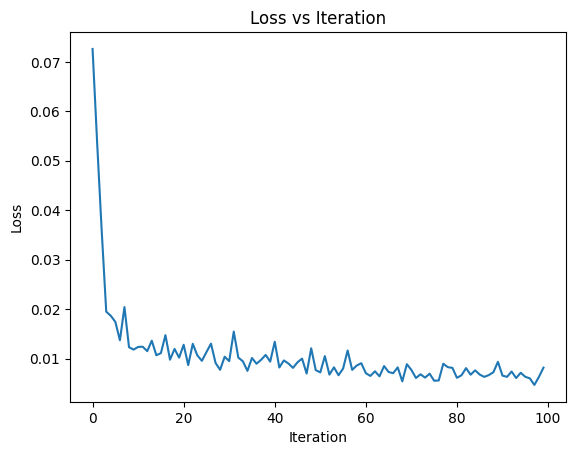

In [101]:
# Plot loss from loss.txt

import matplotlib.pyplot as plt

f = open("loss.txt", "r")

loss = []

for x in f:
    loss.append(float(x))


plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()
